In [1]:
# import tensorflow as tf

In [2]:
# cpus = tf.config.experimental.list_physical_devices('GPU')
# print(cpus)

In [3]:
import pandas as pd
from pathlib import Path

DATA_DIR = f"{Path().resolve(strict=True).parent}/data/"
df = pd.read_parquet(f"{DATA_DIR}/interim/country_codes_as_int.parquet")

https://towardsdatascience.com/spam-detection-in-emails-de0398ea3b48

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df["http_user_agent"], df["is_bot"], test_size=0.2, random_state=3)

In [6]:
max_feature = 50000 #number of unique words to consider
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(X_train)
x_train_features = np.array(tokenizer.texts_to_sequences(X_train))
x_test_features = np.array(tokenizer.texts_to_sequences(X_test))

2022-11-30 20:06:13.694027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 20:06:16.113711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-30 20:06:16.113842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-30 20:06:16.113850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100

In [8]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [9]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train_y = le.fit_transform(target_train.values)
# test_y = le.transform(target_test.values)

In [10]:
import tensorflow as tf
from keras.layers import Dense,LSTM, Embedding, Dropout, Activation, Bidirectional#size of the output vector from each layer
embedding_vector_length = 32#Creating a sequential model
model = tf.keras.Sequential()#Creating an embedding layer to vectorize
model.add(Embedding(max_feature, embedding_vector_length, input_length=max_len))#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))#Relu allows converging quickly and allows backpropagation
model.add(Dense(16, activation='relu'))#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

2022-11-30 20:06:26.436515: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-30 20:06:26.436542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucas-pc): /proc/driver/nvidia/version does not exist
2022-11-30 20:06:26.437907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
______________________________________________

In [11]:
# history = model.fit(x_train_features, Y_train, batch_size=512, epochs=20, validation_data=(x_test_features, Y_test))
# y_predict = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [12]:
history = model.fit(x_train_features, Y_train, batch_size=32, epochs=3, validation_data=(x_test_features, Y_test))

Epoch 1/3
11056/11056 [==============================] - 751s 68ms/step - loss: 0.0209 - accuracy: 0.9929 - val_loss: 0.0146 - val_accuracy: 0.9951
Epoch 2/3
11056/11056 [==============================] - 665s 60ms/step - loss: 0.0144 - accuracy: 0.9950 - val_loss: 0.0135 - val_accuracy: 0.9954
Epoch 3/3
11056/11056 [==============================] - 676s 61ms/step - loss: 0.0136 - accuracy: 0.9951 - val_loss: 0.0130 - val_accuracy: 0.9955


In [13]:
y_predict = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

2764/2764 [==============================] - 30s 11ms/step


In [14]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
cf_matrix =confusion_matrix(Y_test,y_predict)
tn, fp, fn, tp = confusion_matrix(Y_test,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_test, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_test,y_predict)))

Precision: 99.57%
Recall: 99.82%
F1 Score: 99.69%


[Text(0, 0.5, 'Not Spam'), Text(0, 1.5, 'Spam')]

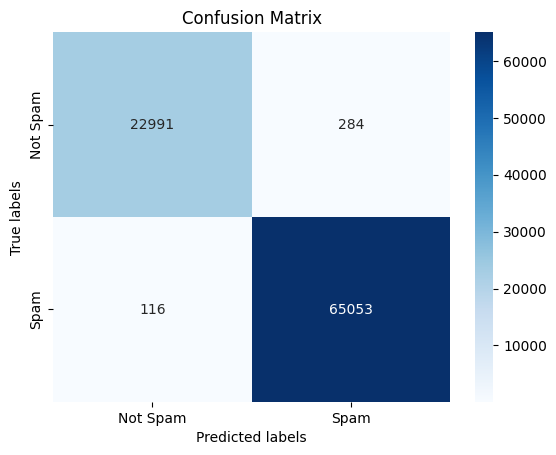

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])

In [16]:
model.save("../models/tf-lstm-full.h5")
model.save("../models/tf-lstm-full-SavedModel")

INFO:tensorflow:Assets written to: models/tf-lstm-full-SavedModel/assets


INFO:tensorflow:Assets written to: models/tf-lstm-full-SavedModel/assets
